In [114]:
# Import statements and set seed
import numpy as np
import random
import matplotlib.pyplot as plt

#np.random.seed(0)
#random.seed(0)


In [115]:
def generate_data(mu, tau, N):
  """Draw N samples from N(mu, tau^{-1}) and return them as a NumPy array."""
  if tau <= 0:
    raise ValueError("Precision tau must be positive.")

  std = np.sqrt(1.0 / tau)
  D = np.random.normal(loc=mu, scale=std, size=N)
  return D

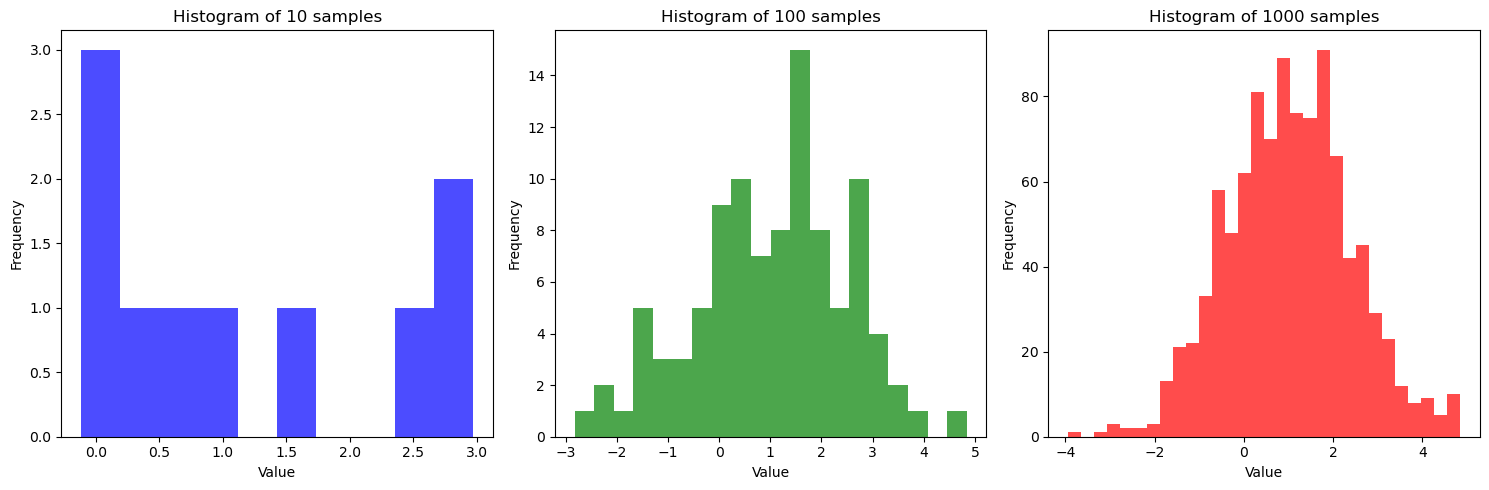

In [116]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms

#Plot histograms of the data:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataset_1, bins=10, alpha=0.7, color='blue')
plt.title('Histogram of 10 samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataset_2, bins=20, alpha=0.7, color='green')
plt.title('Histogram of 100 samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataset_3, bins=30, alpha=0.7, color='red')
plt.title('Histogram of 1000 samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()




# Functions needed for the BBVI:


In [117]:
from scipy.special import digamma, gammaln

def score_function(Theta, mu, tau):
    """Compute the score function ∇_Theta log q(Theta; mu, tau)
      for a Gaussian variational distribution. Take in S samples of mu and tau
      and return the score function for each sample."""
    # Theta contains [mu_n, lambda_N, a_N, b_N]

    partial_mu = Theta[1]* (mu - Theta[0])

    partial_lambda = 1 / (2 * Theta[1]) - 0.5 * ((mu - Theta[0])**2)

    partial_a = - digamma(Theta[2]) + np.log(Theta[3]) + np.log(tau)

    partial_b = Theta[2] / Theta[3] - tau
    
    return np.array([partial_mu, partial_lambda, partial_a, partial_b])

def log_joint(mu, tau, data, mu_0, lambda_0, a_0, b_0):
    """Compute the log joint probability log p(X, mu, tau)
      for the Bayesian Gaussian model."""
    N = len(data)

    # Log prior for mu
    log_prior_mu = -0.5 * np.log(2 * np.pi / (tau*lambda_0)) - 0.5 * lambda_0*tau * (mu - mu_0)**2

    # Log prior for tau
    log_prior_tau = a_0 * np.log(b_0) - gammaln(a_0) + (a_0 - 1) * np.log(tau) - b_0 * tau

    # Log likelihood
    log_likelihood = -N / 2 * np.log(2 * np.pi) + N / 2 * np.log(tau) - 0.5 * tau * np.sum((data - mu)**2)

    return log_prior_mu + log_prior_tau + log_likelihood

def log_variational(Theta, mu, tau):
    """Compute the log variational probability log q(Theta; mu, tau)
      for the Gaussian variational distribution."""
    # Theta contains [mu_n, lambda_N, a_N, b_N]

    # Log q(mu)
    log_q_mu = 0.5*np.log(Theta[1]) - 0.5 * np.log(2 * np.pi) - 0.5 * Theta[1] * (Theta[0] - mu)**2

    # Log q(tau)
    log_q_tau = Theta[2] * np.log(Theta[3]) - gammaln(Theta[2]) + (Theta[2] - 1) * np.log(tau) - Theta[3] * tau

    return log_q_mu + log_q_tau

def elbo_gradient(mu, tau, data, Theta, mu_0, lambda_0, a_0, b_0, S=100):
    """Estimate the gradient of the ELBO using the score function estimator."""
    #mu, tau contains S samples from the variational distributions
    gradients = np.zeros([4, S])  # For mu, lambda, a, b
    for s in range(S):
       

        # Compute log joint and log variational
        log_p = log_joint(mu[s], tau[s], data, mu_0, lambda_0, a_0, b_0)
        log_q = log_variational(Theta, mu[s], tau[s])

        # Compute score function
        score = score_function(Theta, mu[s], tau[s])

        # Compute gradient estimate
        gradients[:, s] = score * (log_p - log_q)
    return np.mean(gradients, axis=1)  # Average over S samples
  


def compute_elbo (D, a_0, b_0, mu_0, lambda_0, mu_N, lambda_N, a_N, b_N ):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here

  N = len(D)

  E_tau = a_N / b_N
  E_log_tau = digamma(a_N) - np.log(b_N)
  
  #SUM E[(x_n - mu)^2]
  E_xn_mu = np.sum((D-mu_N)**2) + N/lambda_N

  #E[(mu - mu_0)^2]
  E_mu_mu_0 = (mu_N - mu_0)**2 + 1/lambda_N

  #E[(mu - mu_N)^2]
  var_mu_q = 1/lambda_N

  #E_q[ln p(D|mu, tau)]
  E_q_like = N/2 * E_log_tau - N/2 * np.log(2*np.pi) - E_tau/2 * E_xn_mu

  #E_q[(ln p(mu|tau))]
  E_q_mu_prior = 1/2 * np.log(lambda_0) + 1/2 * E_log_tau - 1/2 * np.log(2*np.pi) - 1/2 * lambda_0 * E_tau * E_mu_mu_0

  #E_q[ln p(tau)]
  E_q_tau_prior = a_0 * np.log(b_0) - gammaln(a_0) + (a_0 - 1) * E_log_tau - b_0 * E_tau

  #E_q[ln q(mu)]
  E_q_mu_q = 1/2 * np.log(lambda_N) - 1/2 *np.log(2*np.pi) - lambda_N/2 * var_mu_q

  #E_q[ln q(tau)]
  E_q_tau_q = a_N * np.log(b_N) - gammaln(a_N) + (a_N - 1) * E_log_tau - b_N * E_tau

  elbo = E_q_like + E_q_mu_prior + E_q_tau_prior - E_q_mu_q - E_q_tau_q


  return elbo

In [ ]:
from scipy.stats import norm, gamma
def BBVI(mu_0, lambda_0, a_0, b_0, data,
         S = 100, variational_dist = [norm, gamma],
         C = np.array([1, 1, 1, 1])):
    """Perform Black Box Variational Inference to 
    approximate the posterior of a Gaussian model."""
    N = len(data)
    # Initialize variational parameters randomly
    mu_N = np.random.randn()
    lambda_N = 1
    a_N = 1
    b_N = 1
    t = 1
    flag = True

    ELBO = [compute_elbo(data, a_0, b_0, mu_0, lambda_0, mu_N, lambda_N, a_N, b_N)]
    Exp_mu = [mu_N]
    Exp_tau = [a_N / b_N]

    Theta = np.array([mu_N, lambda_N, a_N, b_N])


    while flag:
        #print('iteration: ', t, ' ELBO: ', ELBO[-1], ' Theta: ', Theta)
        # Sample from the variational distributions
        
        z_mu = variational_dist[0].rvs(loc=Theta[0], scale=1/np.sqrt(Theta[1]), size =S)
        z_tau = variational_dist[1].rvs(a=Theta[2], scale=1/Theta[3], size =S)

        #Set rho to t'th value of Robbins-Monro sequence
        rho = 1 / (t + 10000)
        
        old_Theta = Theta.copy()
        #Update each variational parameter
        #Scale the gradient by C to avoid too large updates
        Theta = Theta + rho * (C*elbo_gradient(z_mu, z_tau,
                                            data, Theta, mu_0,
                                            lambda_0, a_0, b_0, S))
        #Ensure positive
        
        #Save values:
        ELBO.append(compute_elbo(data, a_0, b_0, mu_0, lambda_0, *Theta))
        
        Exp_mu.append(Theta[0])
        Exp_tau.append(Theta[2] / Theta[3])
        
        #Check convergence
        if np.linalg.norm(Theta - old_Theta) < 1e-3:
            flag = False
        #chech if theta contains nan and stop if so
        if np.isnan(Theta).any():
            flag = False
            print("NaN detected in Theta, stopping iteration.")
        #update step counter
        t += 1
        

    return Theta, ELBO, Exp_mu, Exp_tau

In [119]:
#Set prior parameters and hyperparameters
mu_0 = 1
lambda_0 = 0.1
a_0 = 1
b_0 = 2




The data mean is:  1.1797458403786378
Final variational parameters:
mu_N: 1.1774892038294953
lambda_N: 2.1647329206999197
a_N: 1.6582713313244521
b_N: 2.2955355023754844
Expected mu: 1.1774892038294953
Expected tau: 0.7223897559451494
Final ELBO: -20.156253266400878


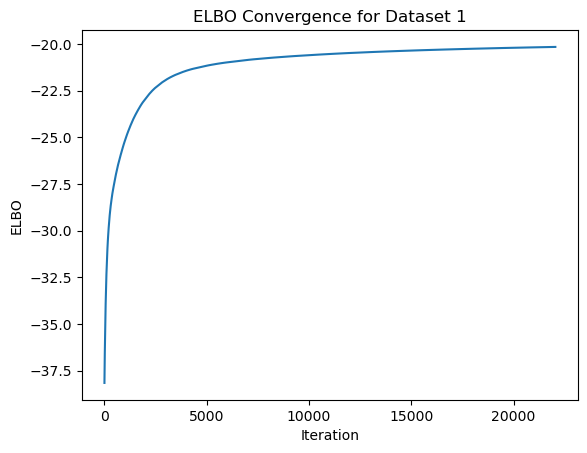

The data mean is:  1.0282230035756386
Final variational parameters:
mu_N: 1.0321823851091285
lambda_N: 5.013788450735291
a_N: 3.0664861173181794
b_N: 6.473858024783485
Expected mu: 1.0321823851091285
Expected tau: 0.47367212959859994
Final ELBO: -197.71046308955823


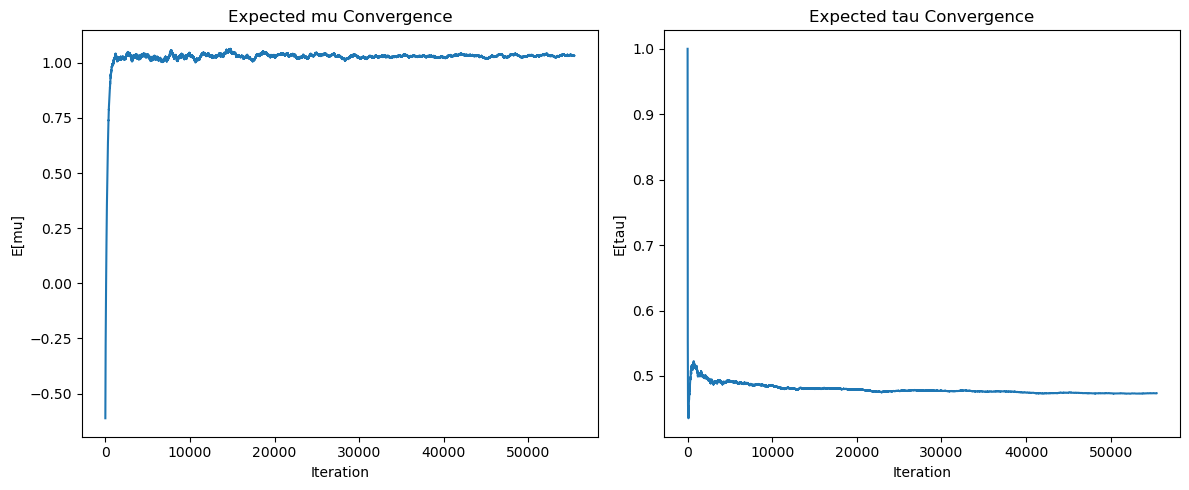

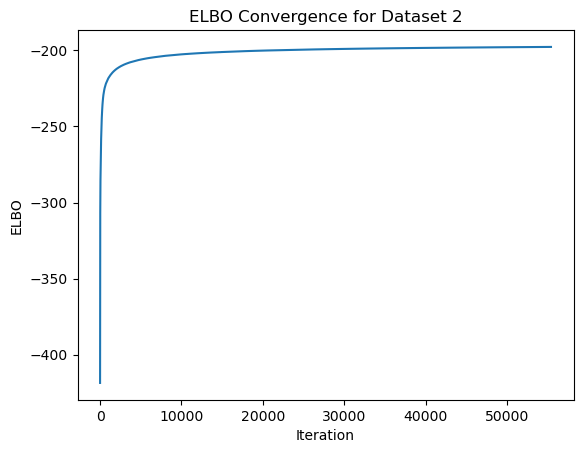

The data mean is:  1.017852194806123
Final variational parameters:
mu_N: 0.997481095599519
lambda_N: 12.759841869078613
a_N: 7.684279983669443
b_N: 14.658440453619898
Expected mu: 0.997481095599519
Expected tau: 0.5242222054919773
Final ELBO: -1805.0429471164266


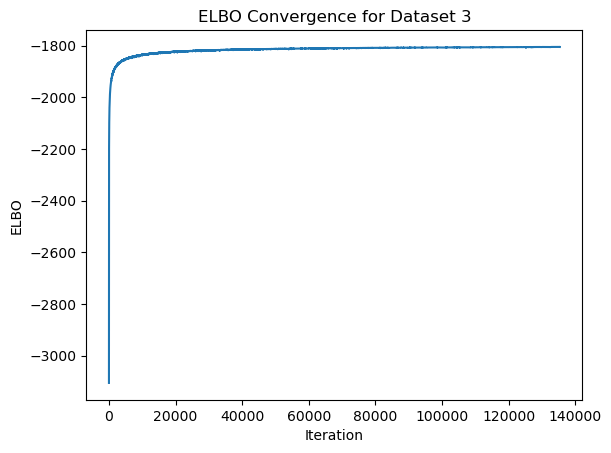

In [120]:
#Run BBVI on each dataset and plot ELBO convergence and print final variational parameters
# S = 1000
from matplotlib import pyplot as plt
i = 1
for data in [dataset_1, dataset_2, dataset_3]:

    print('The data mean is: ', np.mean(data))
    Theta, ELBO, Exp_mu, Exp_tau = BBVI(mu_0, lambda_0, a_0, b_0, data,
                                        S = 1000)
    print("Final variational parameters:")
    print("mu_N:", Theta[0])
    print("lambda_N:", Theta[1])
    print("a_N:", Theta[2])
    print("b_N:", Theta[3])
    print("Expected mu:", Exp_mu[-1])
    print("Expected tau:", Exp_tau[-1])
    print("Final ELBO:", ELBO[-1])
    if i == 2:
        #For Dataset 2, plot expected mu and tau convergence
        #plot and save the ELBO convergence
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(Exp_mu)
        plt.title('Expected mu Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('E[mu]')
        plt.subplot(1, 2, 2)
        plt.plot(Exp_tau)
        plt.title('Expected tau Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('E[tau]')
        plt.tight_layout()
        plt.savefig('Plots/expected_mu_tau_convergence.png')
        plt.show()
        plt.plot(ELBO)
        plt.title('ELBO Convergence for Dataset 2')
        plt.xlabel('Iteration')
        plt.ylabel('ELBO')
        plt.savefig('Plots/ELBO_convergence_dataset2.png')
        plt.show()
    else:
        plt.plot(ELBO)
        plt.title(f'ELBO Convergence for Dataset {i}')
        plt.xlabel('Iteration')
        plt.ylabel('ELBO')
        plt.show()
    i += 1
